# Daftar Isi

1. Deskripsi Proyek
2. Inisialisasi
3. Memuat Data
4. EDA
4. Prosedur Evaluasi
5. Normalisasi
6. Pemisahan Train/Test
7. Bekerja dengan Model
   - 7.1 Model 1 - Konstan
   - 7.2 Model 2 - NLTK, TF-IDF dan LR
   - 7.3 Model 3 - spaCy, TF-IDF dan LR
   - 7.4 Model 4 - spaCy, TF-IDF dan LGBMClassifier
   
8. Ulasan Saya
   - 8.1 Model 2
   - 8.2 Model 3
   - 8.3 Model 4
  
9. Kesimpulan

# Deskripsi Proyek

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengategorikan ulasan film. Misi utamanya adalah melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Gunakan *dataset* ulasan film IMBD dengan pelabelan polaritas untuk membuat sebuah model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya harus memiliki skor F1 sebesar 0,85.

## Inisialisasi

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm

## Memuat data

In [2]:
#muat dataset
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'}).sample(5000)

In [3]:
#cek_data
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
36113,tt0092843,movie,The Dead,The Dead,1987,\N,83,0,Drama,7.3,6907,"I believe John Houston's ""The Dead"" is a true ...",10,pos,1,test,12313
40653,tt0217723,tvEpisode,The Picture of Dorian Gray,The Picture of Dorian Gray,1976,\N,100,0,Drama,7.3,195,"Playwright John Osborne's (Look Back in Anger,...",9,pos,1,test,2881
16993,tt0063094,movie,Hot Millions,Hot Millions,1968,\N,106,0,"Comedy,Crime",6.9,1824,Peter Ustinov plays an embezzler who is just g...,7,pos,1,train,4655
37058,tt0095189,movie,The Further Adventures of Tennessee Buck,The Further Adventures of Tennessee Buck,1988,\N,88,0,"Action,Adventure,Comedy",4.7,505,Although this is generally a cheesy jungle-adv...,4,neg,0,train,8627
12805,tt0423651,tvMiniSeries,Fingersmith,Fingersmith,2005,2005,181,0,"Crime,Drama,Romance",7.9,7866,"I'm not exactly sure why I ordered ""Fingersmit...",7,pos,1,test,10564


In [4]:
#cek kolom 'pos'
df_reviews['pos'].value_counts()

1    2503
0    2497
Name: pos, dtype: int64

In [5]:
#cek kolom 'ds_part'
df_reviews['ds_part'].value_counts()

train    2561
test     2439
Name: ds_part, dtype: int64

In [6]:
#cek ukuran data
df_reviews.shape

(5000, 17)

In [7]:
#cek info dataset
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 36113 to 31022
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           5000 non-null   object 
 1   title_type       5000 non-null   object 
 2   primary_title    5000 non-null   object 
 3   original_title   5000 non-null   object 
 4   start_year       5000 non-null   int64  
 5   end_year         5000 non-null   object 
 6   runtime_minutes  5000 non-null   object 
 7   is_adult         5000 non-null   int64  
 8   genres           5000 non-null   object 
 9   average_rating   4999 non-null   float64
 10  votes            4999 non-null   Int64  
 11  review           5000 non-null   object 
 12  rating           5000 non-null   int64  
 13  sp               5000 non-null   object 
 14  pos              5000 non-null   int64  
 15  ds_part          5000 non-null   object 
 16  idx              5000 non-null   int64  
dtypes: Int64(

In [8]:
#cek missing value
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     1
votes              1
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

## EDA

Periksa jumlah film dan ulasan selama beberapa tahun.

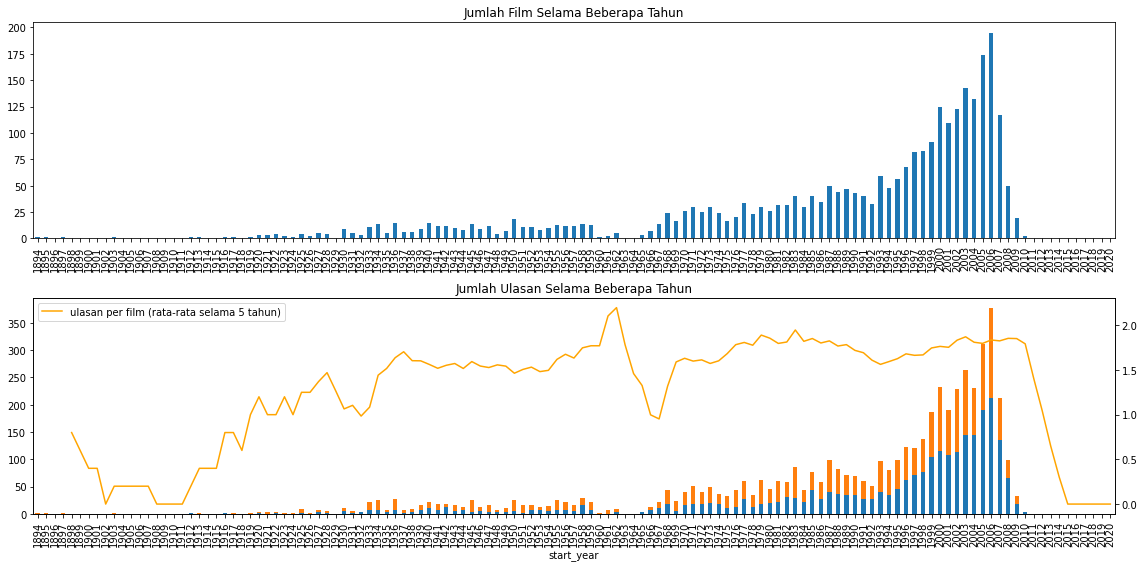

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Beberapa Tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Beberapa Tahun') 

fig.tight_layout()

catatan :
- Jumlah film yang di produksi pada tahun 1930an sampai 1959an berkisar dibawah 25 film
- Jumlah film mulai tahun 1986 sampau 2007 menanjak naik dan kemudian menurun drastis sampai tahun 2009
- namun demikin untuk jumlah ulasan film tiap tahun nya mulai tahun 1930 an sampai dengan 2009 terlihat hampir merata di kisaran 250-325 ulasan

Periksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

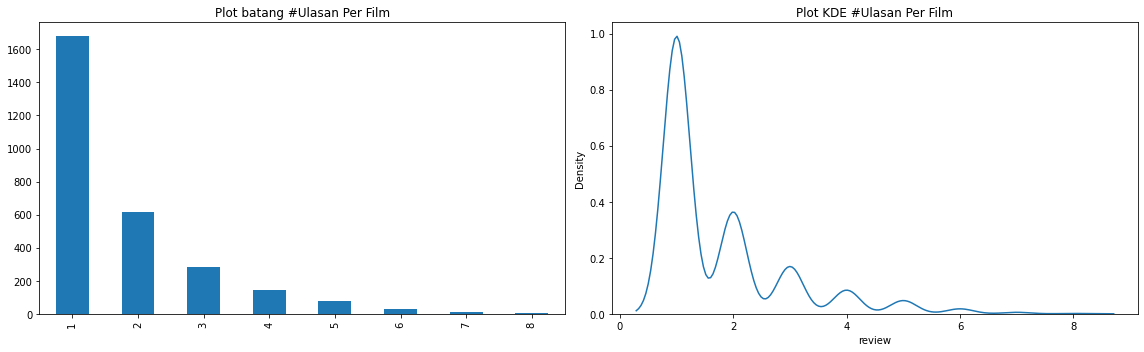

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

catatan :
- terlihat dari Plot batang jumlah ulasan per Film paling banyak sejumlah 1 ulasan dan makin menyusut sampai 8 ulasan perfilm
- sedangakan kepadatan distribusi bisa dilihat dengan Plot Estimasi Distribusi Kernel dalam bentuk data continue

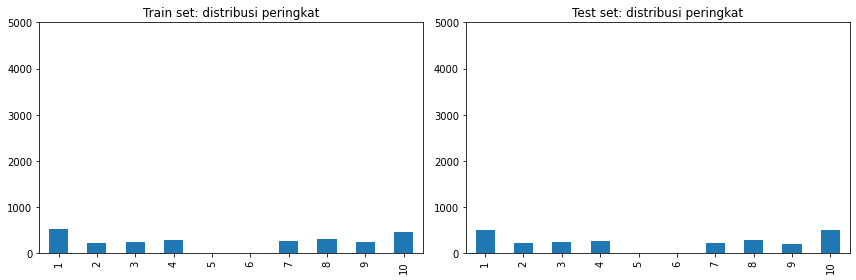

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Test set: distribusi peringkat')

fig.tight_layout()

catatan :
- distribusi peringkat dari data train set dan test set terlihat balanced/seimbang


Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian *dataset*

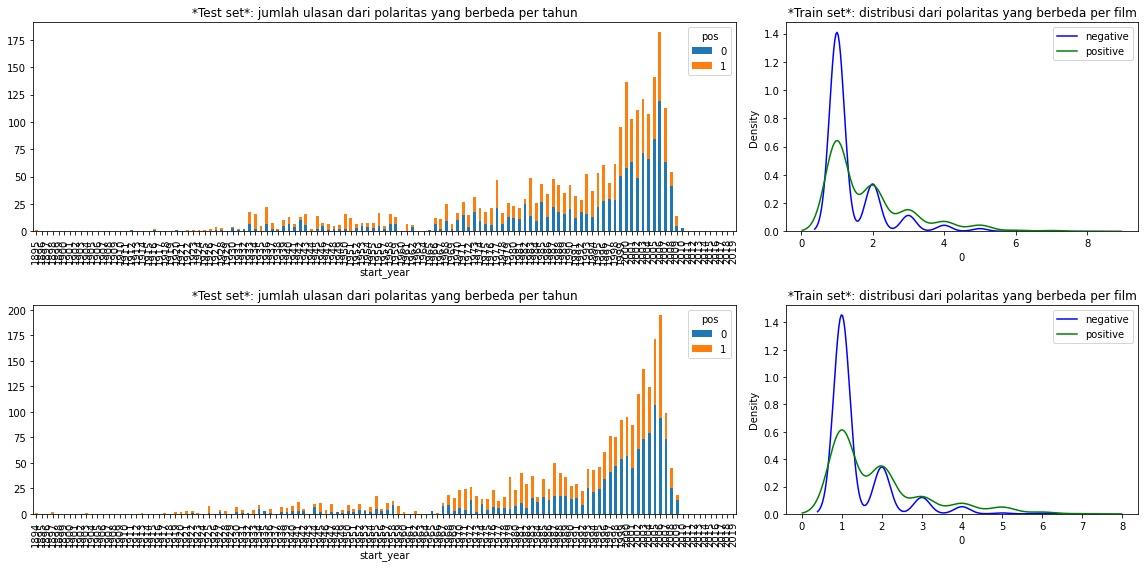

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('*Test set*: jumlah ulasan dari polaritas yang berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('*Train set*: distribusi dari polaritas yang berbeda per film')

fig.tight_layout()

catatan :
- pada data train dan data test terlihat perbandingan distribusi ulasan positif di tahun 2000an makin menurun dibandingkan awal tahun 1930 an
- sedangkan untuk per film menunjukkan sentimen negative lebih banyak ketika ulasan nya sedikit dan sentimen negative lebih sedikit ketika ulasan nya lebih dari 2 ulasan

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [13]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Akurasi'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Akurasi', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalisasi

Kita menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [14]:
#rubah ke text lowercase tanpa angka, tanda baca dll
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')

In [15]:
#cek kolom review
df_reviews['review']

36113    I believe John Houston's "The Dead" is a true ...
40653    Playwright John Osborne's (Look Back in Anger,...
16993    Peter Ustinov plays an embezzler who is just g...
37058    Although this is generally a cheesy jungle-adv...
12805    I'm not exactly sure why I ordered "Fingersmit...
                               ...                        
26472    This show can most accurately be described as ...
27410    "Quai des Orfevres", directed by the brilliant...
42188    I first saw this mini-series a number of years...
42761    I love movies, and I'll watch any movie all th...
31022    Sisters in law will be released theatrically o...
Name: review, Length: 5000, dtype: object

In [16]:
#cek kolom review_norm
df_reviews['review_norm']

36113    i believe john houston s  the dead  is a true ...
40653    playwright john osborne s  look back in anger ...
16993    peter ustinov plays an embezzler who is just g...
37058    although this is generally a cheesy jungle adv...
12805    i m not exactly sure why i ordered  fingersmit...
                               ...                        
26472    this show can most accurately be described as ...
27410     quai des orfevres   directed by the brilliant...
42188    i first saw this mini series a number of years...
42761    i love movies  and i ll watch any movie all th...
31022    sisters in law will be released theatrically o...
Name: review_norm, Length: 5000, dtype: object

## Pemisahan Train / Test

Untungnya, seluruh *dataset* sudah dibagi menjadi *train/test*. Bendera yang sesuai adalah 'ds_part'.

In [17]:
#define dataset untuk train dan test
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(2561, 18)
(2439, 18)


## Bekerja dengan Model

### Model 1 - Konstan

In [18]:
from sklearn.dummy import DummyClassifier

         train  test
Akurasi   0.50  0.50
F1        0.67  0.67
APS       0.50  0.50
ROC AUC   0.50  0.50


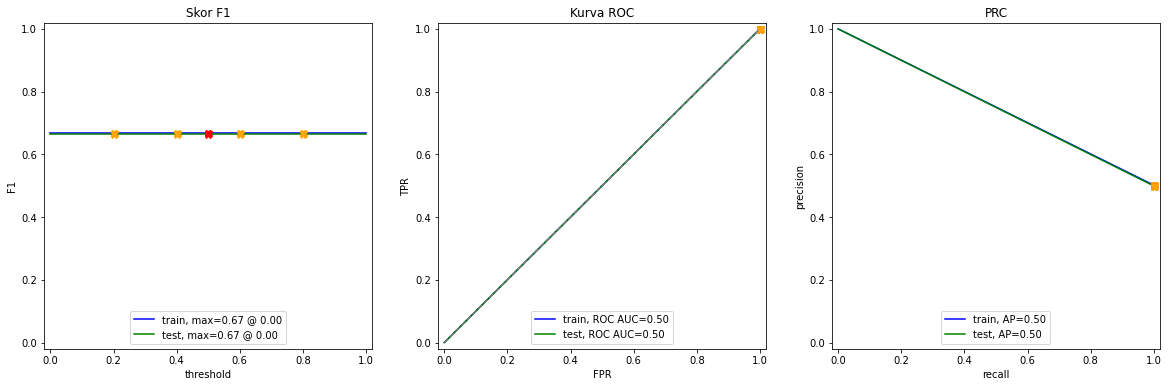

In [19]:
#dummyclassifier untuk model konstant
dummy_clf = DummyClassifier(strategy='constant', constant=1)
model_1 = dummy_clf.fit(X=df_reviews_train, y=train_target)
evaluate_model (model_1,np.empty(len(train_target)),train_target,np.empty(len(test_target)), test_target)


catatan :
- skor F1 nilainya konstant untuk data train 0.68, dan data test 0.67
- kurva ROC masing-masing  0.5 baik untuk train dan test
- sedangkan nilai APS untuk train adalah 0.52 dan test 0.5

### Model 2 - NLTK, TF-IDF dan LR

TF-IDF

In [20]:
import nltk

nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression



[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
#define train features dan test features
tfidf_vectorizer_1 = TfidfVectorizer(stop_words = stopwords.words('english'), lowercase=True)

train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
print (train_features_1.shape)

test_features_1 = tfidf_vectorizer_1.transform (df_reviews_test['review_norm'])
print (test_features_1.shape)

(2561, 28173)
(2439, 28173)


In [22]:
#fitting model
modelLR = LogisticRegression(penalty='l1', solver = 'liblinear', C=0.5)
modelLR.fit(train_features_1,train_target)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

         train  test
Akurasi   0.77  0.75
F1        0.79  0.77
APS       0.84  0.81
ROC AUC   0.85  0.83


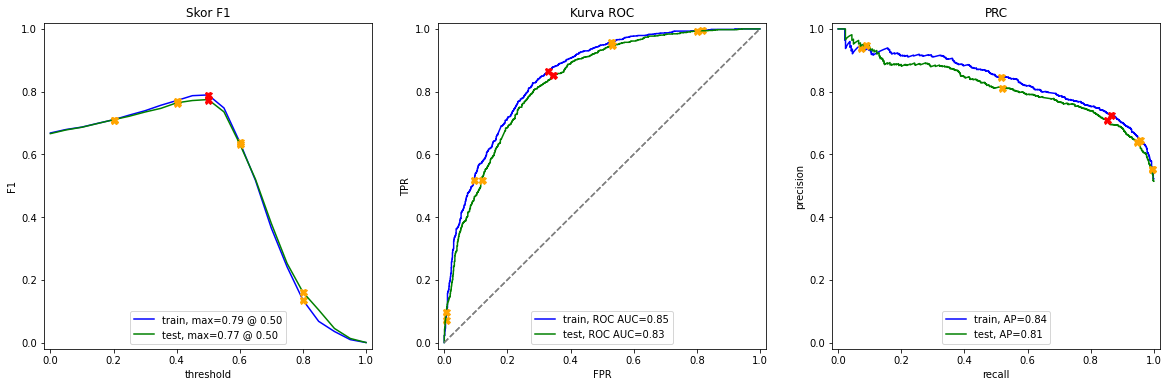

In [23]:
#evaluasi model
evaluate_model(modelLR, train_features_1, train_target, test_features_1, test_target)

catatan :
- pada model LinearRegression dengan NLTK dan TF-IDF didapatkan :
  - F1 bergerak dengan angka maksimum pada train 0.79 dan test 0.77
  - ROC-AUC bergerak dengan angka maksimum pada train 0.85 dan test 0.84
  - recall bergerak dengan angka maksimum pada train 0.85 dan test 0.84

### Model 3 - spaCy, TF-IDF dan LR

In [24]:
#inisiasi spaCy
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [25]:
#define text preprocessing
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [26]:
#text preprocessing data train
df_reviews_train['review_tokenized_3'] = df_reviews_train['review_norm'].apply(lambda x: text_preprocessing_3(x))

In [27]:
#text preprocessing data test
df_reviews_test['review_tokenized_3'] = df_reviews_test['review_norm'].apply(lambda x: text_preprocessing_3(x))

In [28]:
#cek sample data train
df_reviews_train['review_tokenized_3'].sample (3)

6871     the second half of steven soderbergh s revolut...
14141    it take gut to make a movie on gandhi in india...
40552    I really like this movie because I have a husb...
Name: review_tokenized_3, dtype: object

In [29]:
#cek sample data test
df_reviews_test['review_tokenized_3'].sample(3)

43752    this be a classic animate film from the cartoo...
36120    the entire movie   an artful adaptation of one...
2250     american movie be a wonderful documentary   it...
Name: review_tokenized_3, dtype: object

In [30]:
##define train features dan test features
tfidf_vectorizer_3 = TfidfVectorizer()

train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_tokenized_3'])
print (train_features_3.shape)

test_features_3 = tfidf_vectorizer_3.transform (df_reviews_test['review_tokenized_3'])
print (test_features_3.shape)

(2561, 22842)
(2439, 22842)


In [31]:
#fitting model
modelLR3 = LogisticRegression(penalty='l1', solver = 'liblinear', C=0.5)
modelLR3.fit(train_features_3,train_target)

LogisticRegression(C=0.5, penalty='l1', solver='liblinear')

         train  test
Akurasi   0.77  0.75
F1        0.79  0.77
APS       0.85  0.82
ROC AUC   0.86  0.83


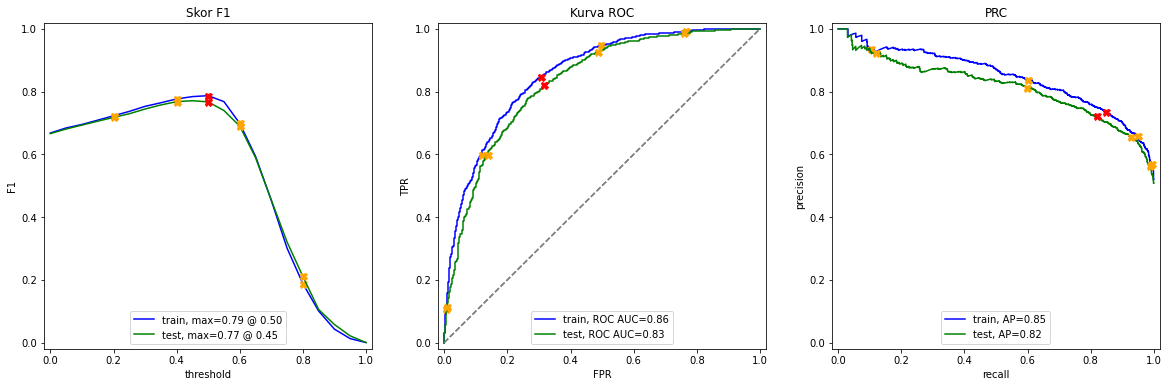

In [32]:
#evaluasi model
evaluate_model(modelLR3, train_features_3, train_target, test_features_3, test_target)

catatan :
- pada model LinearRegression dengan spaCy dan TF-IDF didapatkan :
  - F1 bergerak dengan angka maksimum pada train 0.8 dan test 0.77
  - ROC-AUC bergerak dengan angka maksimum pada train 0.85 dan test 0.84
  - recall bergerak dengan angka maksimum pada train 0.85 dan test 0.83

### Model 4 - spaCy, TF-IDF dan LGBMClassifier

In [33]:
from lightgbm import LGBMClassifier

In [34]:
modelLGBM = LGBMClassifier(learning_rate = 0.04, max_depth=4)
modelLGBM.fit(train_features_3, train_target)

LGBMClassifier(learning_rate=0.04, max_depth=4)

         train  test
Akurasi   0.86  0.77
F1        0.87  0.79
APS       0.95  0.84
ROC AUC   0.95  0.86


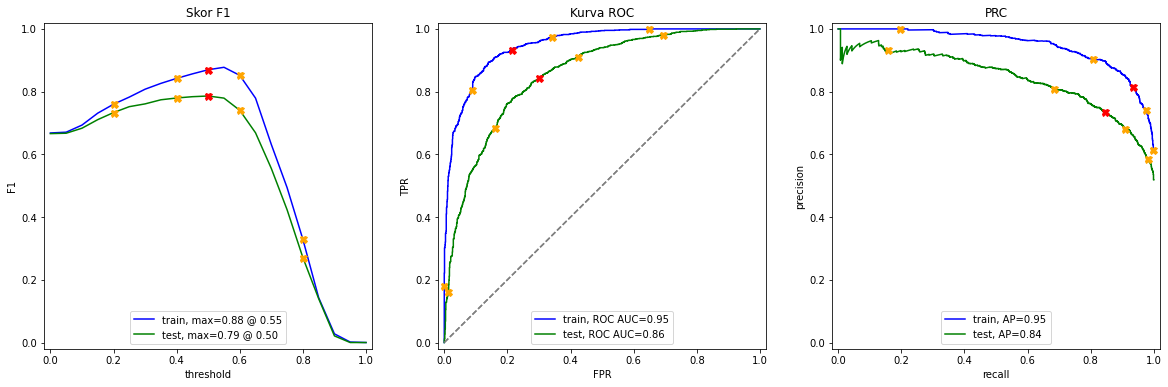

In [35]:
evaluate_model(modelLGBM, train_features_3, train_target, test_features_3, test_target)

catatan :
- pada model LGBMClassifier dengan spaCy dan TF-IDF didapatkan :
  - F1 bergerak dengan angka maksimum pada train 0.86 dan test 0.79
  - ROC-AUC bergerak dengan angka maksimum pada train 0.87 dan test 0.81
  - recall bergerak dengan angka maksimum pada train 0.86 dan test 0.79

In [36]:
# Model 5 - BERT 
#import torch
#import transformers

In [37]:
#tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
#3config = transformers.BertConfig.from_pretrained('bert-base-uncased')
#model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [38]:
#def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
 #   ids_list = []
 #   attention_mask_list = []

    # teks ke id token yang sudah di-padded bersamaan dengan attention mask
    
    # <masukkan kode di sini untuk ids_list dan attention_mask_list>
    
 #   if force_device is not None:
 #       device = torch.device(force_device)
 #   else:
 #       device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
 #   model.to(device)
 #   if not disable_progress_bar:
 #       print(f'Gunakan {perangkat} perangkat.')
    
    # dapatkan embedding dalam batch 

 #   embeddings = []

 #   for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
 #       ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <masukkan kode di sini untuk membuat attention_mask_batch 
            
 #       with torch.no_grad():            
 #           model.eval()
 #           batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
 #       embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
 #   return np.concatenate(embeddings)

In [39]:
# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [40]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [41]:
# jika sudah mendapatkan embedding, disarankan untuk menyimpannya agar siap 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# dan muat...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## Ulasan Saya

In [42]:
#membuat kolom ulasan / review

my_reviews = pd.DataFrame([
    'I dont like it very much, not my favorite kind of movie', 
    'Its boring, even I slept in the middle of the movie', 
    'The movie is so good, I really like it',     
    'Even the actors look very old and have no interest in the movie, whether they are paid to play the movie. Its really not qualified.', 
    'I didnt expect the movie to be so good! The writers really paid attention to every detail', 
    'This movie has its advantages and disadvantages, but I feel overall it is a decent film. Ill probably watch it again.', 
    'Some of his jokes are really not funny. Not a single joke works, everyone is acting annoying, even children wont like this!', 
    'Showing this movie on Netflix is a bold move & Im so excited to be watching episode after episode of this exciting and smart new drama.' 
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x : text_preprocessing_3(x))
my_reviews

,review,review_norm
0,"I dont like it very much, not my favorite kind...","I do not like it very much , not my favorite k..."
1,"Its boring, even I slept in the middle of the ...","its boring , even I sleep in the middle of the..."
2,"The movie is so good, I really like it","the movie be so good , I really like it"
3,Even the actors look very old and have no inte...,even the actor look very old and have no inter...
4,I didnt expect the movie to be so good! The wr...,I do not expect the movie to be so good ! the ...
5,This movie has its advantages and disadvantage...,this movie have its advantage and disadvantage...
6,Some of his jokes are really not funny. Not a ...,some of his joke be really not funny . not a s...
7,Showing this movie on Netflix is a bold move &...,show this movie on Netflix be a bold move & I ...


### Model 2

In [43]:
#prediksi ulasan dengan model NLTK, TF-IDF dan LR
texts = my_reviews['review_norm']

my_reviews_pred_prob = modelLR.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.48:  I do not like it very much , not my favorite kind of movie
0.02:  its boring , even I sleep in the middle of the movie
0.53:  the movie be so good , I really like it
0.33:  even the actor look very old and have no interest in the movie , whether they be pay to play the mov
0.55:  I do not expect the movie to be so good ! the writer really pay attention to every detail
0.52:  this movie have its advantage and disadvantage , but I feel overall it be a decent film . Ill probab
0.41:  some of his joke be really not funny . not a single joke work , everyone be act annoying , even chil
0.53:  show this movie on Netflix be a bold move & I m so excited to be watch episode after episode of this


### Model 3

In [44]:
#prediksi ulasan dengan model spaCy, TF-IDF dan LR
texts = my_reviews['review_norm']

my_reviews_pred_prob = modelLR3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.60:  I do not like it very much , not my favorite kind of movie
0.08:  its boring , even I sleep in the middle of the movie
0.86:  the movie be so good , I really like it
0.27:  even the actor look very old and have no interest in the movie , whether they be pay to play the mov
0.60:  I do not expect the movie to be so good ! the writer really pay attention to every detail
0.64:  this movie have its advantage and disadvantage , but I feel overall it be a decent film . Ill probab
0.46:  some of his joke be really not funny . not a single joke work , everyone be act annoying , even chil
0.56:  show this movie on Netflix be a bold move & I m so excited to be watch episode after episode of this


### Model 4

In [45]:
#prediksi ulasan dengan model spaCy, TF-IDF dan LGBMClassifier
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = modelLGBM.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.66:  I do not like it very much , not my favorite kind of movie
0.35:  its boring , even I sleep in the middle of the movie
0.67:  the movie be so good , I really like it
0.54:  even the actor look very old and have no interest in the movie , whether they be pay to play the mov
0.66:  I do not expect the movie to be so good ! the writer really pay attention to every detail
0.65:  this movie have its advantage and disadvantage , but I feel overall it be a decent film . Ill probab
0.61:  some of his joke be really not funny . not a single joke work , everyone be act annoying , even chil
0.65:  show this movie on Netflix be a bold move & I m so excited to be watch episode after episode of this


## Kesimpulan

Kesimpulan :
- pada model LinearRegression dengan NLTK dan TF-IDF didapatkan :
  - F1 bergerak dengan angka maksimum pada train 0.79 dan test 0.77
  - ROC-AUC bergerak dengan angka maksimum pada train 0.85 dan test 0.84
  - recall bergerak dengan angka maksimum pada train 0.85 dan test 0.84
- pada model LinearRegression dengan spaCy dan TF-IDF didapatkan :
  - F1 bergerak dengan angka maksimum pada train 0.8 dan test 0.77
  - ROC-AUC bergerak dengan angka maksimum pada train 0.85 dan test 0.84
  - recall bergerak dengan angka maksimum pada train 0.85 dan test 0.83
- pada model LGBMClassifier dengan spaCy dan TF-IDF didapatkan :
  - F1 bergerak dengan angka maksimum pada train 0.86 dan test 0.79
  - ROC-AUC bergerak dengan angka maksimum pada train 0.87 dan test 0.81
  - recall bergerak dengan angka maksimum pada train 0.86 dan test 0.79
- Model ke-4 (model spaCy, TF-IDF dan LGBMClassifier) memberikan nilai prediksi pada ulasan yang lebih besar di bandingkan model 2 dan 3